In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyfolio as pf
import yfinance as yf
import talib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

## Importing the Data

In [2]:
apple = yf.Ticker('aapl')

aapl = apple.history(start='2020-01-01', end = '2022-01-01', interval= '1d')
aapl

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,72.883149,73.955832,72.624823,73.894325,135480400,0.0,0.0
2020-01-03,73.107046,73.950919,72.947130,73.175934,146322800,0.0,0.0
2020-01-06,72.280368,73.798353,72.024498,73.758987,118387200,0.0,0.0
2020-01-07,73.768852,74.029641,73.188231,73.412117,108872000,0.0,0.0
2020-01-08,73.109488,74.900567,73.109488,74.593033,132079200,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-27,176.864657,180.190422,176.844694,180.100540,74919600,0.0,0.0
2021-12-28,179.930762,181.099272,178.302832,179.061859,79144300,0.0,0.0
2021-12-29,179.101809,180.400158,177.913321,179.151749,62348900,0.0,0.0


In [3]:
aapl = aapl.drop(['Volume', 'Dividends','Stock Splits'], axis=1)

In [4]:
aapl.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

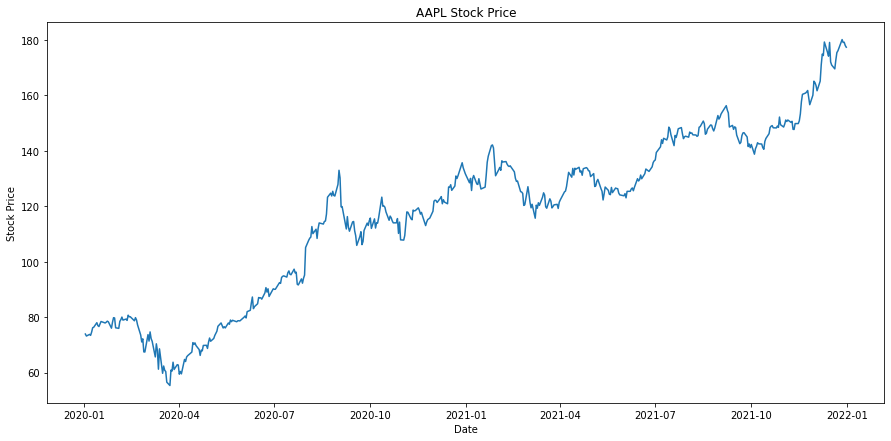

In [5]:
plt.figure(figsize=(15, 7))

# Line Plot of the Stock Price
sns.lineplot(data=aapl, x=aapl.index, y='Close')

plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

## Data Engineering

### Input Parameters

In [6]:
# 3-day Moving Average
aapl['3_day_MA'] = talib.MA(aapl['Close'].values, 3)

In [7]:
# 15-day Moving Average
aapl['15_day_MA'] = talib.MA(aapl['Close'].values, 15)

In [8]:
# 3-month Moving Average
aapl['60_day_MA'] = talib.MA(aapl['Close'].values, 60)

In [9]:
# Correlation Indicator
aapl['Corr'] = talib.CORREL(aapl['Close'], aapl['3_day_MA'], timeperiod=10)

In [10]:
# Difference of High and Open
aapl['STD_U'] = aapl['High'] - aapl['Open']

In [11]:
# Difference of Open and Low
aapl['STD_D'] = aapl['Open'] - aapl['Low']

In [12]:
# Market Open Change
aapl['OD'] = aapl['Open'] - aapl['Open'].shift(1)

In [13]:
# Overnight Change
aapl['OL'] = aapl['Close'].shift(1) - aapl['Open']

In [14]:
aapl

,Open,High,Low,Close,3_day_MA,15_day_MA,60_day_MA,Corr,STD_U,STD_D,OD,OL
Date,,,,,,,,,,,,
2020-01-02,72.883149,73.955832,72.624823,73.894325,NaN,NaN,NaN,NaN,1.072683,0.258326,NaN,NaN
2020-01-03,73.107046,73.950919,72.947130,73.175934,NaN,NaN,NaN,NaN,0.843872,0.159916,0.223898,0.787279
2020-01-06,72.280368,73.798353,72.024498,73.758987,73.609749,NaN,NaN,NaN,1.517984,0.255871,-0.826678,0.895565
2020-01-07,73.768852,74.029641,73.188231,73.412117,73.449013,NaN,NaN,NaN,0.260788,0.580621,1.488484,-0.009865
2020-01-08,73.109488,74.900567,73.109488,74.593033,73.921379,NaN,NaN,NaN,1.791079,0.000000,-0.659364,0.302629
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,176.864657,180.190422,176.844694,180.100540,177.190913,174.001645,156.377412,0.684042,3.325765,0.019964,1.238408,-0.808963
2021-12-28,179.930762,181.099272,178.302832,179.061859,178.406031,174.931792,156.990762,0.746570,1.168509,1.627931,3.066105,0.169778
2021-12-29,179.101809,180.400158,177.913321,179.151749,179.438049,175.477764,157.663950,0.806036,1.298349,1.188488,-0.828953,-0.039950


### Creating X and y Datasets

In [15]:
# X - Independent Variables
aapl_df = aapl

In [16]:
# Dependent Variable for upward deviation
yU = aapl['STD_U']

In [17]:
# Dependent variable for downward deviation
yD = aapl['STD_D']

#### Data Cleaning

In [18]:
aapl_df.isna().sum()

Open          0
High          0
Low           0
Close         0
3_day_MA      2
15_day_MA    14
60_day_MA    59
Corr         11
STD_U         0
STD_D         0
OD            1
OL            1
dtype: int64

In [19]:
# Drop all the na value rows
aapl_df.dropna(inplace=True)

# Checking for NaN values
aapl_df.isna().sum()

Open         0
High         0
Low          0
Close        0
3_day_MA     0
15_day_MA    0
60_day_MA    0
Corr         0
STD_U        0
STD_D        0
OD           0
OL           0
dtype: int64

In [20]:
# Variables 
# Independent Var
X = aapl_df[['Open', '3_day_MA', '15_day_MA', '60_day_MA', 'OD', 'OL', 'Corr']]

## Data Preprocessing

### Pipeline Building

In [21]:
# Steps of Pipeline
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]

# Defining Pipeline
pipeline = Pipeline(steps)

### Hyperparameter

In [22]:
# The intercept is used as a hyperparameter
parameters = {'linear__fit_intercept': [0, 1]}

### Grid Search Cross-Validation

In [23]:
# TimeSeriesSplit for CV
ts_cv = TimeSeriesSplit(n_splits=5)

# Reg for GridSearch
reg = GridSearchCV(pipeline, parameters, cv=ts_cv)

### Splitting into Train and Test Data


In [24]:
split = .7

split = int(split*len(aapl))

# Train Dataset
X_train = X[:split]
yU_train = yU[:split]
yD_train = yD[:split]

# Test Dataset
X_test = X[split:]

### Prediction

In [25]:
# Fit the model
reg.fit(X_train, yU_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [26]:
# Best Parameter
reg.best_params_

{'linear__fit_intercept': 0}

In [27]:
# Predict the upward devation
yU_predict = reg.predict(X_test)

In [28]:
# Fit the model
reg.fit(X_train, yD_train)

# Best Parameter
print(reg.best_params_)

# Predict downward deviation
yD_predict = reg.predict(X_test)


{'linear__fit_intercept': 1}


In [29]:
# New column in X_text
X_test['yU_predict'] = yU_predict
X_test['yD_predict'] = yD_predict

# Assigning 0's to all negative values
X_test.loc[X_test['yU_predict'] < 0, 'yU_predict'] = 0
X_test.loc[X_test['yD_predict'] < 0, 'yD_predict'] = 0

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/2242340115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['yU_predict'] = yU_predict
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/2242340115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['yD_predict'] = yD_predict


In [48]:
# Add open values in ['yU_predict'] to get the predicted high column
X_test['P_H'] = X_test['Open']+X_test['yU_predict']

# Subtract ['yD_predict'] values in open to get the predicted low column.
X_test['P_L'] = X_test['Open']-X_test['yD_predict']

# Print tail of aapl_df dataframe
X_test.tail()

,Open,3_day_MA,15_day_MA,60_day_MA,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low,Signal,aapl_returns,strategy_returns,returns
Date,,,,,,,,,,,,,,,,,,
2021-12-27,176.864657,177.190913,174.001645,156.377412,1.238408,-0.808963,0.684042,0.294175,2.723417,177.158832,174.141240,180.100540,180.190422,176.844694,-1,0.022975,-0.022975,0.022975
2021-12-28,179.930762,178.406031,174.931792,156.990762,3.066105,0.169778,0.746570,0.407857,2.579682,180.338619,177.351080,179.061859,181.099272,178.302832,-1,-0.005767,0.005767,-0.005767
2021-12-29,179.101809,179.438049,175.477764,157.663950,-0.828953,-0.039950,0.806036,0.285542,2.486345,179.387352,176.615464,179.151749,180.400158,177.913321,-1,0.000502,-0.000502,0.000502
2021-12-30,179.241640,178.728953,175.685499,158.284753,0.139830,-0.089891,0.819017,0.314698,2.413584,179.556338,176.828056,177.973251,180.340246,177.863391,-1,-0.006578,0.006578,-0.006578
2021-12-31,177.863383,178.156352,175.885911,158.880277,-1.378257,0.109869,0.852172,0.266344,2.406146,178.129726,175.457237,177.344055,179.001931,177.034437,-1,-0.003535,0.003535,-0.003535


In [31]:
# Copy columns from aapl_df to X_test
X_test[['Close', 'High', 'Low']] = aapl_df[['Close', 'High', 'Low']][split:]
X_test

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3717386873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['Close', 'High', 'Low']] = aapl_df[['Close', 'High', 'Low']][split:]
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3717386873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['Close', 'High', 'Low']] = aapl_df[['Close', 'High', 'Low']][split:]
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3717386873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,Open,3_day_MA,15_day_MA,60_day_MA,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low
Date,,,,,,,,,,,,,,
2021-06-23,133.205515,132.764043,128.466259,128.195358,1.633072,0.209112,0.929547,0.137059,1.884891,133.342574,131.320624,133.135803,133.753197,132.667785
2021-06-24,133.882635,133.132487,129.121482,128.422949,0.677120,-0.746832,0.913704,0.099318,1.663612,133.981954,132.219023,132.847031,134.071836,132.369045
2021-06-25,132.896823,132.843709,129.600784,128.608282,-0.985812,-0.049793,0.867998,0.085276,1.679948,132.982099,131.216876,132.548294,133.325001,132.249557
2021-06-28,132.847029,133.202189,130.190286,128.807249,-0.049794,-0.298735,0.914939,0.068810,1.854205,132.915839,130.992824,134.211243,134.679261,132.787284
2021-06-29,134.231157,134.171412,130.826921,128.983891,1.384129,-0.019915,0.909778,0.117952,1.963620,134.349109,132.267537,135.754700,135.914028,133.783059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,176.864657,177.190913,174.001645,156.377412,1.238408,-0.808963,0.684042,0.294175,2.723417,177.158832,174.141240,180.100540,180.190422,176.844694
2021-12-28,179.930762,178.406031,174.931792,156.990762,3.066105,0.169778,0.746570,0.407857,2.579682,180.338619,177.351080,179.061859,181.099272,178.302832
2021-12-29,179.101809,179.438049,175.477764,157.663950,-0.828953,-0.039950,0.806036,0.285542,2.486345,179.387352,176.615464,179.151749,180.400158,177.913321


In [32]:
test_dataset = X_test

In [33]:
# Initialising signal column to be zero
test_dataset['Signal'] = 0

# When selling, assigning signal value as -1
test_dataset.loc[(test_dataset['High'] > test_dataset['P_H']) & (
    test_dataset['Low'] > test_dataset['P_L']), 'Signal'] = -1

# When buying, assigning signal value as +1
test_dataset.loc[(test_dataset['High'] < test_dataset['P_H']) & (
    test_dataset['Low'] < test_dataset['P_L']), 'Signal'] = 1

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/1736651914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['Signal'] = 0


In [34]:
test_dataset

,Open,3_day_MA,15_day_MA,60_day_MA,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low,Signal
Date,,,,,,,,,,,,,,,
2021-06-23,133.205515,132.764043,128.466259,128.195358,1.633072,0.209112,0.929547,0.137059,1.884891,133.342574,131.320624,133.135803,133.753197,132.667785,-1
2021-06-24,133.882635,133.132487,129.121482,128.422949,0.677120,-0.746832,0.913704,0.099318,1.663612,133.981954,132.219023,132.847031,134.071836,132.369045,-1
2021-06-25,132.896823,132.843709,129.600784,128.608282,-0.985812,-0.049793,0.867998,0.085276,1.679948,132.982099,131.216876,132.548294,133.325001,132.249557,-1
2021-06-28,132.847029,133.202189,130.190286,128.807249,-0.049794,-0.298735,0.914939,0.068810,1.854205,132.915839,130.992824,134.211243,134.679261,132.787284,-1
2021-06-29,134.231157,134.171412,130.826921,128.983891,1.384129,-0.019915,0.909778,0.117952,1.963620,134.349109,132.267537,135.754700,135.914028,133.783059,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,176.864657,177.190913,174.001645,156.377412,1.238408,-0.808963,0.684042,0.294175,2.723417,177.158832,174.141240,180.100540,180.190422,176.844694,-1
2021-12-28,179.930762,178.406031,174.931792,156.990762,3.066105,0.169778,0.746570,0.407857,2.579682,180.338619,177.351080,179.061859,181.099272,178.302832,-1
2021-12-29,179.101809,179.438049,175.477764,157.663950,-0.828953,-0.039950,0.806036,0.285542,2.486345,179.387352,176.615464,179.151749,180.400158,177.913321,-1


In [35]:
# Compute aapl returns
test_dataset['aapl_returns'] = test_dataset['Close'].pct_change()

# Compute strategy returns
test_dataset['strategy_returns'] = test_dataset['aapl_returns'] * (test_dataset['Signal'].shift(1))

# Printing test_dataset
test_dataset

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/763273183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['aapl_returns'] = test_dataset['Close'].pct_change()
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/763273183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['strategy_returns'] = test_dataset['aapl_returns'] * (test_dataset['Signal'].shift(1))


,Open,3_day_MA,15_day_MA,60_day_MA,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low,Signal,aapl_returns,strategy_returns
Date,,,,,,,,,,,,,,,,,
2021-06-23,133.205515,132.764043,128.466259,128.195358,1.633072,0.209112,0.929547,0.137059,1.884891,133.342574,131.320624,133.135803,133.753197,132.667785,-1,NaN,NaN
2021-06-24,133.882635,133.132487,129.121482,128.422949,0.677120,-0.746832,0.913704,0.099318,1.663612,133.981954,132.219023,132.847031,134.071836,132.369045,-1,-0.002169,0.002169
2021-06-25,132.896823,132.843709,129.600784,128.608282,-0.985812,-0.049793,0.867998,0.085276,1.679948,132.982099,131.216876,132.548294,133.325001,132.249557,-1,-0.002249,0.002249
2021-06-28,132.847029,133.202189,130.190286,128.807249,-0.049794,-0.298735,0.914939,0.068810,1.854205,132.915839,130.992824,134.211243,134.679261,132.787284,-1,0.012546,-0.012546
2021-06-29,134.231157,134.171412,130.826921,128.983891,1.384129,-0.019915,0.909778,0.117952,1.963620,134.349109,132.267537,135.754700,135.914028,133.783059,-1,0.011500,-0.011500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,176.864657,177.190913,174.001645,156.377412,1.238408,-0.808963,0.684042,0.294175,2.723417,177.158832,174.141240,180.100540,180.190422,176.844694,-1,0.022975,-0.022975
2021-12-28,179.930762,178.406031,174.931792,156.990762,3.066105,0.169778,0.746570,0.407857,2.579682,180.338619,177.351080,179.061859,181.099272,178.302832,-1,-0.005767,0.005767
2021-12-29,179.101809,179.438049,175.477764,157.663950,-0.828953,-0.039950,0.806036,0.285542,2.486345,179.387352,176.615464,179.151749,180.400158,177.913321,-1,0.000502,-0.000502


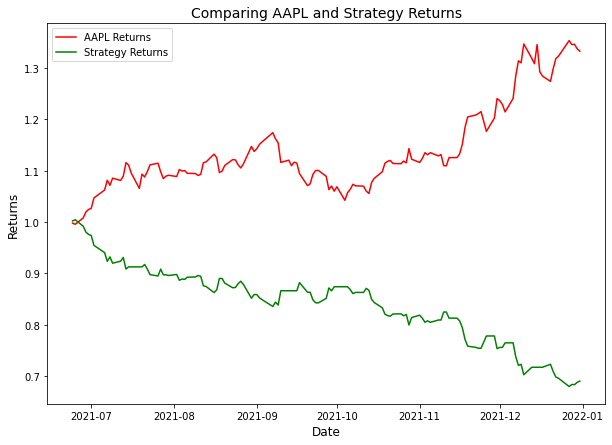

In [36]:
plt.figure(figsize=(10, 7))

# Plotting gld_returns
plt.plot(((test_dataset['aapl_returns'][:]+1).cumprod()),
         color='r', label='AAPL Returns')

# Plotting test_dataset
plt.plot(((test_dataset['strategy_returns'][:]+1).cumprod()),
         color='g', label='Strategy Returns')

# x-labeling
plt.xlabel('Date', fontsize=12)

# y-labeling
plt.ylabel('Returns', fontsize=12)

# Titlename
plt.title('Comparing AAPL and Strategy Returns', fontsize=14)
plt.legend()
plt.show()

In [37]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()


# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = test_dataset['strategy_returns'] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe -3.844615255942967


In [38]:
 def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    #intializing trade as datframe
    trades = pd.DataFrame()
    current_position = 0
    
    # Creating an empty string for entry_date
    entry_date = ''

    for i in data.index:
        
        # New Signal position
        new_position = data.loc[i, signal_column]
        
        # Using conditional statements to get all the trading days from the data.
        if new_position != current_position:    
             # To understand below two conditional statements see test_dataset dataframe signal column.
             # Take first row apply these conditions and then apply it on second row, third row and few more rows  to grasp the full idea.   
            if entry_date != '':                   
                entry_price = data.loc[entry_date, close_column]
                exit_date = i
                exit_price = data.loc[exit_date, close_column]
                trade_details = pd.DataFrame([(current_position,entry_date, entry_price, exit_date,exit_price)])
                trades = trades.append(trade_details,ignore_index=True)  
                entry_date = ''            

            if new_position != 0:
                entry_date = i
            current_position = new_position

    # Creating below five columns in trades dataframe.
    trades.columns = ['Position','Entry Date','Entry Price','Exit Date','Exit Price']
    trades['PnL'] = (trades['Exit Price'] - trades['Entry Price']) * trades['Position']
    return trades


In [39]:
def get_analytics(trades):
    """Function to generate strategy analytics
    """

    analytics = pd.DataFrame(index=['Strategy'])
    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position == 1])
    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position == -1])
    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + analytics.num_of_short

    # Gross Profit
    analytics['gross_profit'] = trades.loc[trades.PnL > 0].PnL.sum()
    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL < 0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[trades.PnL > 0])
    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL <= 0])
    # Win percentage
    analytics['win_percentage'] = 100*analytics.winners/analytics.total_trades
    # Loss percentage
    analytics['loss_percentage'] = 100*analytics.losers/analytics.total_trades
    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL > 0].PnL.mean()
    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL <= 0].PnL.mean()

    return analytics.T

In [41]:
# Using get_trades function to evalute trades detail
trades = get_trades(test_dataset, 'Close', 'Signal')
print('Trade Details')

# Printing trades datframe
trades.head()

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3418006546.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trades = trades.append(trade_details,ignore_index=True)


Trade Details


,Position,Entry Date,Entry Price,Exit Date,Exit Price,PnL
0,-1,2021-06-23,133.135803,2021-07-12,143.890228,-10.754425
1,1,2021-07-12,143.890228,2021-07-13,145.025421,1.135193
2,-1,2021-07-13,145.025421,2021-07-15,147.853424,-2.828003
3,-1,2021-07-20,145.533264,2021-07-27,146.150650,-0.617386
4,1,2021-07-27,146.150650,2021-07-28,144.368210,-1.782440


C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3166065150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset_for_plot['long_entry'] = test_dataset_for_plot.Signal == 1
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/3166065150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset_for_plot['short_entry'] = test_dataset_for_plot.Signal == -1


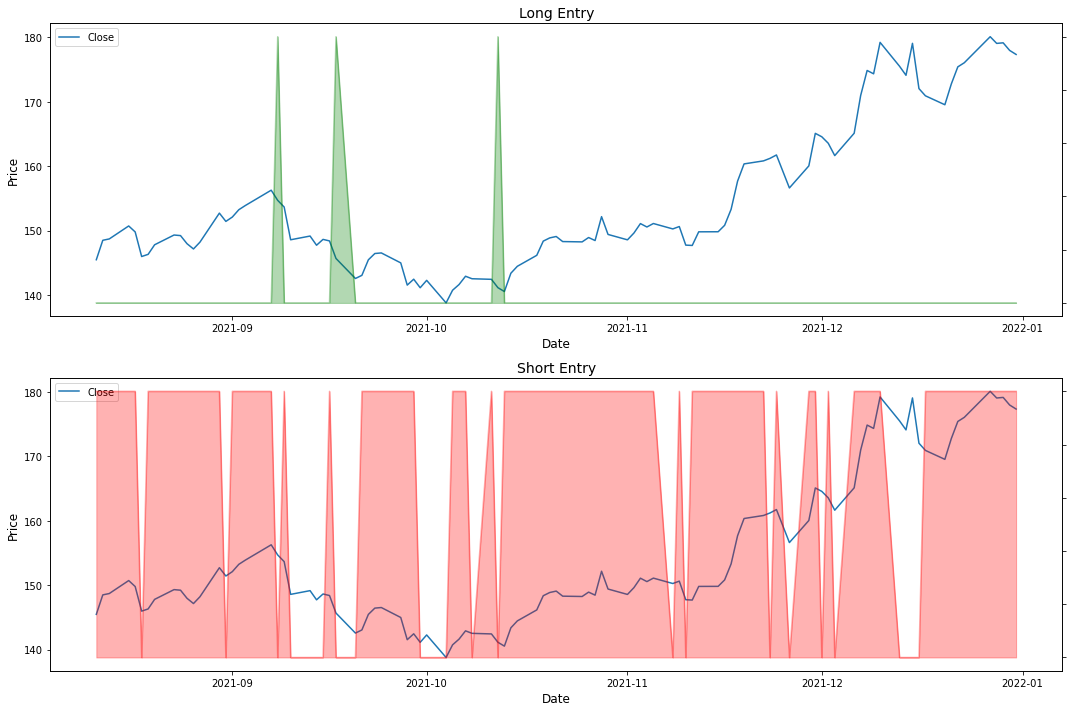

In [42]:
import matplotlib.pyplot as plt

# Showing the last 100 points for illustration purpose
test_dataset_for_plot = test_dataset[-100:]

# When signal is 1 we take long entry
test_dataset_for_plot['long_entry'] = test_dataset_for_plot.Signal == 1

# When signal is -1 we take short entry
test_dataset_for_plot['short_entry'] = test_dataset_for_plot.Signal == -1

fig = plt.figure(figsize=(15, 10))

# Sub plot for the long entry
ax = fig.add_subplot(211)

# Plotting close price
ax.plot(test_dataset_for_plot['Close'], label='Close')

# Set the title and axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()


# Twinx() creates a new axes with an invisible x-axis and y axis positioned opposite to the original one
ax2 = ax.twinx()

# Plotting long entry
ax2.plot(test_dataset_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['long_entry'].index,
                 test_dataset_for_plot['long_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Plot the close price
ax.plot(test_dataset_for_plot['Close'], label='Close')


# Set the title and axis labels
ax.set_title('Short Entry', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()

# Plotting short entry
ax2 = ax.twinx()
ax2.plot(test_dataset_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['short_entry'].index,
                 test_dataset_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

In [43]:
# Calling get_analytics to analyse trades
analytics = get_analytics(trades)
print('Trade Analytics')

# Rounding off to two decimal places
round(analytics, 2)

Trade Analytics


,Strategy
num_of_long,5.00
num_of_short,18.00
total_trades,23.00
gross_profit,22.09
gross_loss,-69.34
net_profit,-47.24
winners,8.00
losers,15.00
win_percentage,34.78
loss_percentage,65.22


In [44]:
# Caculating close price change percentage
test_dataset['returns'] = test_dataset.Close.pct_change()

# Strategy return depends on the last day signal
test_dataset['strategy_returns'] = test_dataset['returns'] * \
    test_dataset['Signal'].shift(1)
test_dataset.head()

C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/956215827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['returns'] = test_dataset.Close.pct_change()
C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/956215827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['strategy_returns'] = test_dataset['returns'] * \


,Open,3_day_MA,15_day_MA,60_day_MA,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low,Signal,aapl_returns,strategy_returns,returns
Date,,,,,,,,,,,,,,,,,,
2021-06-23,133.205515,132.764043,128.466259,128.195358,1.633072,0.209112,0.929547,0.137059,1.884891,133.342574,131.320624,133.135803,133.753197,132.667785,-1,NaN,NaN,NaN
2021-06-24,133.882635,133.132487,129.121482,128.422949,0.677120,-0.746832,0.913704,0.099318,1.663612,133.981954,132.219023,132.847031,134.071836,132.369045,-1,-0.002169,0.002169,-0.002169
2021-06-25,132.896823,132.843709,129.600784,128.608282,-0.985812,-0.049793,0.867998,0.085276,1.679948,132.982099,131.216876,132.548294,133.325001,132.249557,-1,-0.002249,0.002249,-0.002249
2021-06-28,132.847029,133.202189,130.190286,128.807249,-0.049794,-0.298735,0.914939,0.068810,1.854205,132.915839,130.992824,134.211243,134.679261,132.787284,-1,0.012546,-0.012546,0.012546
2021-06-29,134.231157,134.171412,130.826921,128.983891,1.384129,-0.019915,0.909778,0.117952,1.963620,134.349109,132.267537,135.754700,135.914028,133.783059,-1,0.011500,-0.011500,0.011500


C:\Users\ronak\AppData\Local\Temp/ipykernel_79880/659475523.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset.dropna(inplace = True)
C:\Users\ronak\Anaconda3\envs\finance\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2021-06-24
End date,2021-12-31
Total months,6
,Backtest
Annual return,-50.4%
Cumulative returns,-30.9%
Annual volatility,19.0%
Sharpe ratio,-3.58
Calmar ratio,-1.56
Stability,0.89
Max drawdown,-32.3%


C:\Users\ronak\Anaconda3\envs\finance\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Users\ronak\Anaconda3\envs\finance\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
C:\Users\ronak\Anaconda3\envs\finance\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)


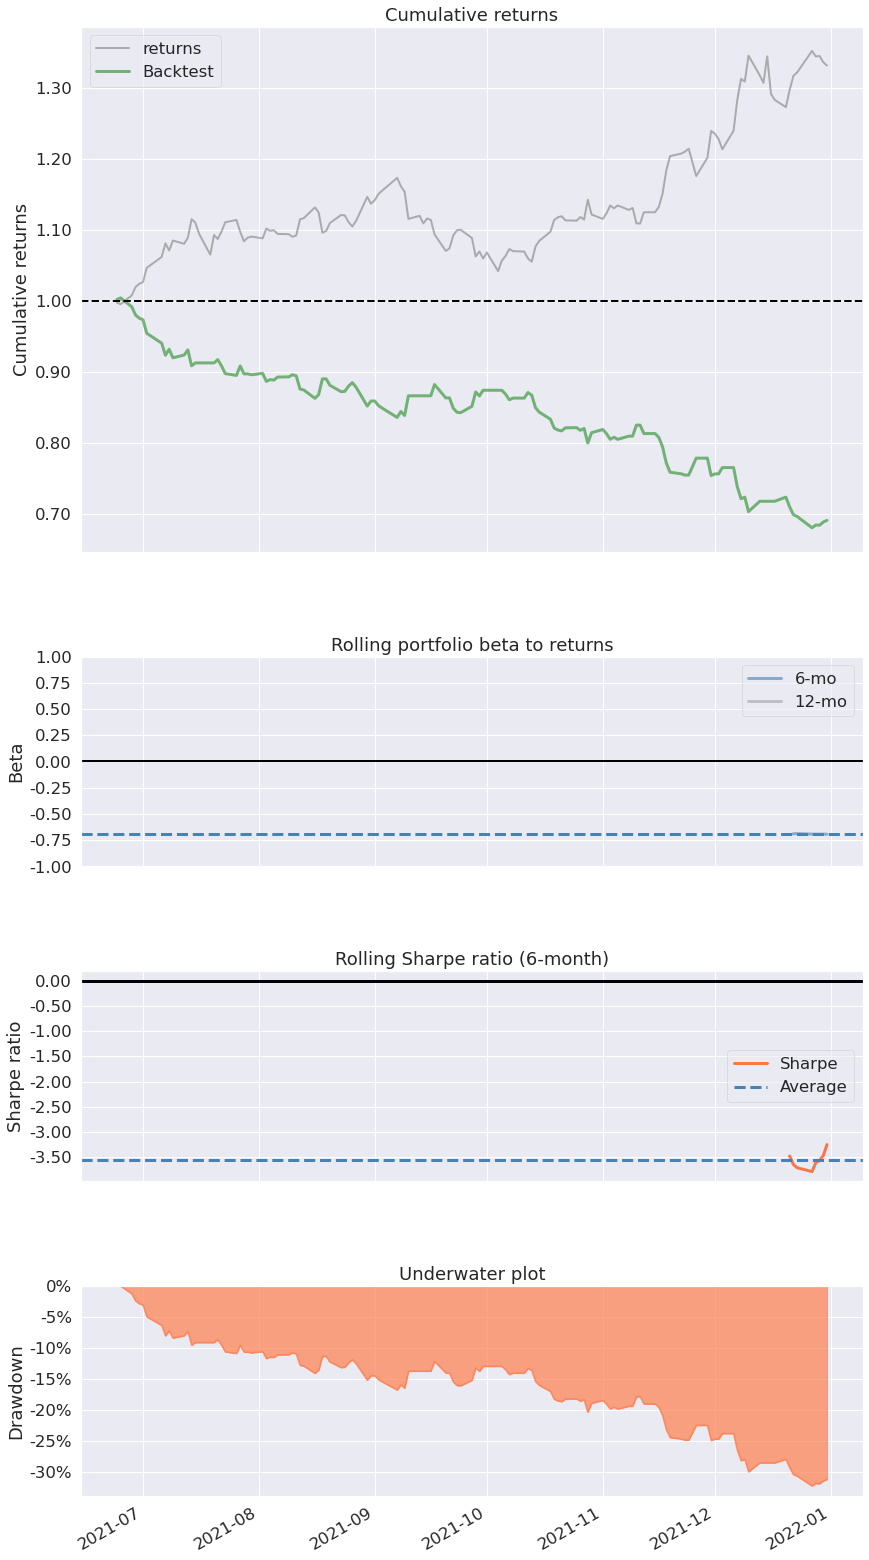

In [46]:
#Checking for NaN values
test_dataset.isna().sum()

# Dropping the NaN values 
test_dataset.dropna(inplace = True)
test_dataset.head()

# Creating pyfolio tear sheet
pf.create_simple_tear_sheet(test_dataset['strategy_returns'], benchmark_rets = test_dataset['returns']) 

**Important Notes:**
1. The strategy performed poorly as the strategy returns are significantly lower than the benchmark
2. There is a negative sharpe ratio indicating the strategies negative return
3. The maximum drawdown is very high reaching a bit below 30% 
**Next Steps:**
1. Collect more data for the model to train more accurately
2. Add more indicators or features in order to improve the strategy performance